## Grids of bounding box of India at 10km spatial resolution 


✅ Saved 90000 10 km grid points (with or without NaNs) to 'grids_10km_india_box.csv'


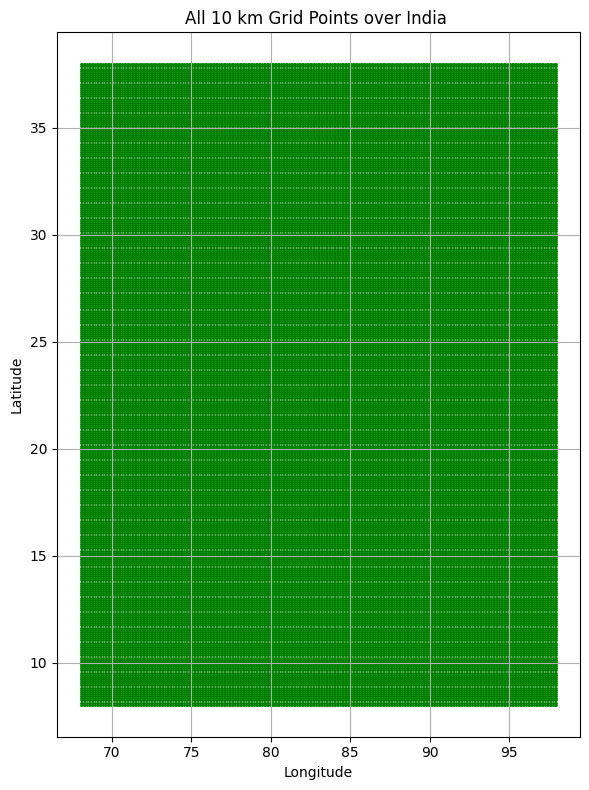

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

###########################################################################################################################
# Import file from the following link: https://zenodo.org/communities/ecnu_lghap/records?q=&l=list&p=1&s=10&sort=newest 
###########################################################################################################################
# Load NetCDF file
ds = xr.open_dataset('LGHAP.Global_PM25.D001.A20190201.nc')  # Replace with your filename
# Step 2: Subset to India
ds_india = ds.sel(lat=slice(8, 38), lon=slice(68, 98))

# Step 3: Coarsen by factor of 5 (spatial resolution)
coarse_ds = ds_india.coarsen(lat=10, lon=10, boundary='trim').mean()

# Step 4: Extract lat/lon grid
lat = coarse_ds['lat'].values
lon = coarse_ds['lon'].values

lon_grid, lat_grid = np.meshgrid(lon, lat)
unique_grids = pd.DataFrame({
    'lat': lat_grid.ravel(),
    'lon': lon_grid.ravel()
})

# Step 5: Save grid points to CSV
unique_grids.to_csv('grids_10km_india_box.csv', index=False)
print(f"✅ Saved {len(unique_grids)} 10 km grid points (with or without NaNs) to 'grids_10km_india_box.csv'")

# Optional: Visualize
plt.figure(figsize=(6, 8))
plt.scatter(unique_grids['lon'], unique_grids['lat'], s=1, color='green')
plt.title('All 10 km Grid Points over India ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# Grids inside shapefile of India

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load shapefile
gdf_boundary = gpd.read_file("india_shp/india.shp")

# ✅ Ensure CRS is set (if missing)
if gdf_boundary.crs is None:
    gdf_boundary.set_crs("EPSG:4326", inplace=True)
else:
    gdf_boundary = gdf_boundary.to_crs("EPSG:4326")

# Load your grid points
df = pd.read_csv("grids_10km_india_box.csv")
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Use spatial join (super fast)
gdf_inside = gpd.sjoin(gdf_points, gdf_boundary, predicate='within', how='inner')

# Save to CSV
gdf_inside.drop(columns=['geometry', 'index_right']).to_csv('india_10km_unique_grids.csv', index=False)

print(f"✅ Done! Saved {len(gdf_inside)} grid points inside India.")

✅ Done! Saved 58101 grid points inside India.


# Grid inside study area (Center, North-east or North) shapefile

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

####### Load shapefile (Center, North-east or North). Change the path as needed ##########
gdf_boundary = gpd.read_file("center_shp/center.shp")

# ✅ Ensure CRS is set (if missing)
if gdf_boundary.crs is None:
    gdf_boundary.set_crs("EPSG:4326", inplace=True)
else:
    gdf_boundary = gdf_boundary.to_crs("EPSG:4326")

# Load your grid points
df = pd.read_csv("grids_10km_india_box.csv")
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Use spatial join (super fast)
gdf_inside = gpd.sjoin(gdf_points, gdf_boundary, predicate='within', how='inner')

# Save to CSV
gdf_inside.drop(columns=['geometry', 'index_right']).to_csv('study_area_10km_unique_grids.csv', index=False)

print(f"✅ Done! Saved {len(gdf_inside)} grid points inside India.")

✅ Done! Saved 3904 grid points inside India.


Visualizing grids for inspection

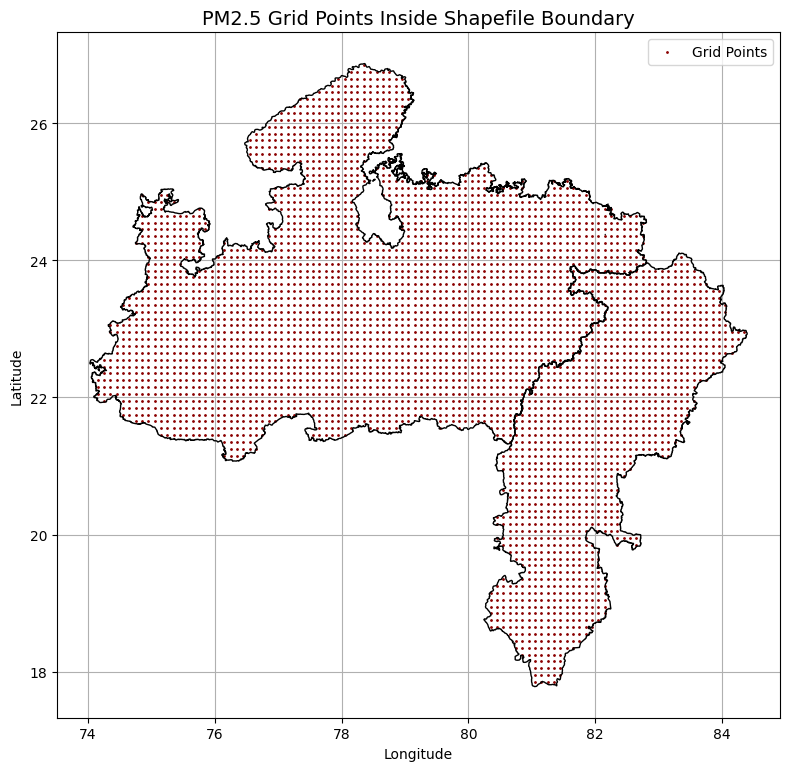

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load shapefile
shapefile_path = 'center_shp/center.shp'
gdf_boundary = gpd.read_file(shapefile_path)

# 🧠 Set CRS if it's missing
if gdf_boundary.crs is None:
    gdf_boundary.set_crs("EPSG:4326", inplace=True)  # Assume WGS84 if not set
else:
    gdf_boundary = gdf_boundary.to_crs("EPSG:4326")

# Load filtered grid points
df = pd.read_csv('study_area_10km_unique_grids.csv')
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
gdf_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
gdf_points.plot(ax=ax, markersize=1, color='darkred', label='Grid Points')

plt.title('PM2.5 Grid Points Inside Shapefile Boundary', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Forest fire griding data (India)

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load the grid file (which has lat/lon grid points)
grid_df = pd.read_csv('india_10km_unique_grids.csv')  # Replace with actual file
grid_points = grid_df[['lat', 'lon']].drop_duplicates().values

# Build KDTree from grid points
tree = cKDTree(grid_points)

# Load the point file
##########################################################################
## Download the fire archive data from the following link: https://firms.modaps.eosdis.nasa.gov/download/
##########################################################################

point_df = pd.read_csv('fire_archive_M-C61_570219.csv')  # Replace with your file
points = point_df[['latitude', 'longitude']].values

# Query the tree for nearest neighbors
distances, indices = tree.query(points)

# Get nearest lat/lon for each point
nearest_points = grid_points[indices]
point_df['nearest_lat'] = nearest_points[:, 0]
point_df['nearest_lon'] = nearest_points[:, 1]

# Optionally, get index values (like grid ID or state info) by merging back with grid_df
point_df = point_df.merge(
    grid_df[['lat', 'lon']],  # Add more columns if needed
    left_on=['nearest_lat', 'nearest_lon'],
    right_on=['lat', 'lon'],
    how='left'
)

# Save output
point_df.to_csv('fire_data_points_only.csv', index=False)

print(point_df.head())

   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   26.8083    95.3742       308.2   1.1    1.0  2001-01-01       429   
1   26.8083    95.3742       308.2   1.1    1.0  2001-01-01       429   
2   26.9708    95.6775       331.1   1.1    1.0  2001-01-01       429   
3   26.9708    95.6775       331.1   1.1    1.0  2001-01-01       429   
4   26.9694    95.6878       331.1   1.1    1.0  2001-01-01       429   

  satellite instrument  confidence  version  bright_t31   frp daynight  type  \
0     Terra      MODIS          67     6.03       288.6   8.6        D     0   
1     Terra      MODIS          67     6.03       288.6   8.6        D     0   
2     Terra      MODIS          87     6.03       288.2  33.2        D     0   
3     Terra      MODIS          87     6.03       288.2  33.2        D     0   
4     Terra      MODIS          87     6.03       289.3  33.3        D     0   

   nearest_lat  nearest_lon    lat    lon  
0        26.85        95.35  26.85  

Aggregating forest fire for daily temporal resolution

In [7]:
# Import required libraries
import pandas as pd

# Load CSV data
df = pd.read_csv('fire_data_points_only.csv')

# Filter rows where confidence is greater than 75
df = df[df['confidence'] > 30]

# Group by unique latitude, longitude pairs, and acquisition date
grouped = df.groupby(['nearest_lat', 'nearest_lon', 'acq_date'])

# Calculate number of rows and sum of "frp" values
result = grouped.agg(
    count=('frp', 'size'),
    sum_frp=('frp', 'sum')
).reset_index()

# Rename columns
result = result.rename(columns={
    'nearest_lat': 'lat',
    'nearest_lon': 'lon',
    'acq_date': 'date'
})

# Export results to CSV
result.to_csv('grid_fire.csv', index=False)

# Display the result
print(result.head())

    lat    lon        date  count  sum_frp
0  8.15  77.45  2002-03-12      2     15.6
1  8.15  77.45  2002-06-08      2     22.6
2  8.15  77.45  2002-09-23      2     16.6
3  8.15  77.45  2008-06-08      2     21.0
4  8.15  77.45  2013-03-13      4     47.4


# Daily forest fires in the Study area

In [8]:
import pandas as pd

# Load updated grid_fire file with 'lat' and 'lon'
grid_fire_df = pd.read_csv('grid_fire.csv')

# Load your grid metadata file
grid_metadata_df = pd.read_csv('study_area_10km_unique_grids.csv')  # Replace with actual filename

# Optional: Drop duplicates in grid metadata to avoid duplicated rows in merge
grid_metadata_df = grid_metadata_df.drop_duplicates(subset=['lat', 'lon'])

# Merge to attach STATE, ID, etc. to fire records
filtered_df = pd.merge(grid_fire_df, grid_metadata_df, on=['lat', 'lon'], how='inner')
# Round lat/lon to 2 decimal places (you can change this if needed)
filtered_df['lat'] = filtered_df['lat'].astype(float).round(2)
filtered_df['lon'] = filtered_df['lon'].astype(float).round(2)

# Save result
filtered_df.to_csv('study_area_forest_fires.csv', index=False)

# Show result
print(filtered_df.head())

     lat    lon        date  count  sum_frp         STATE  State_LGD  \
0  17.85  81.05  2003-02-21      2     74.2  CHHAtT|SGARH         22   
1  17.85  81.05  2003-02-22      2     26.8  CHHAtT|SGARH         22   
2  17.85  81.05  2003-03-06      2     14.2  CHHAtT|SGARH         22   
3  17.85  81.05  2003-03-24      2     52.2  CHHAtT|SGARH         22   
4  17.85  81.05  2004-03-26      2     16.0  CHHAtT|SGARH         22   

     Shape_Leng    Shape_Area  ID  
0  3.321743e+06  1.303554e+11   7  
1  3.321743e+06  1.303554e+11   7  
2  3.321743e+06  1.303554e+11   7  
3  3.321743e+06  1.303554e+11   7  
4  3.321743e+06  1.303554e+11   7  


Visualization

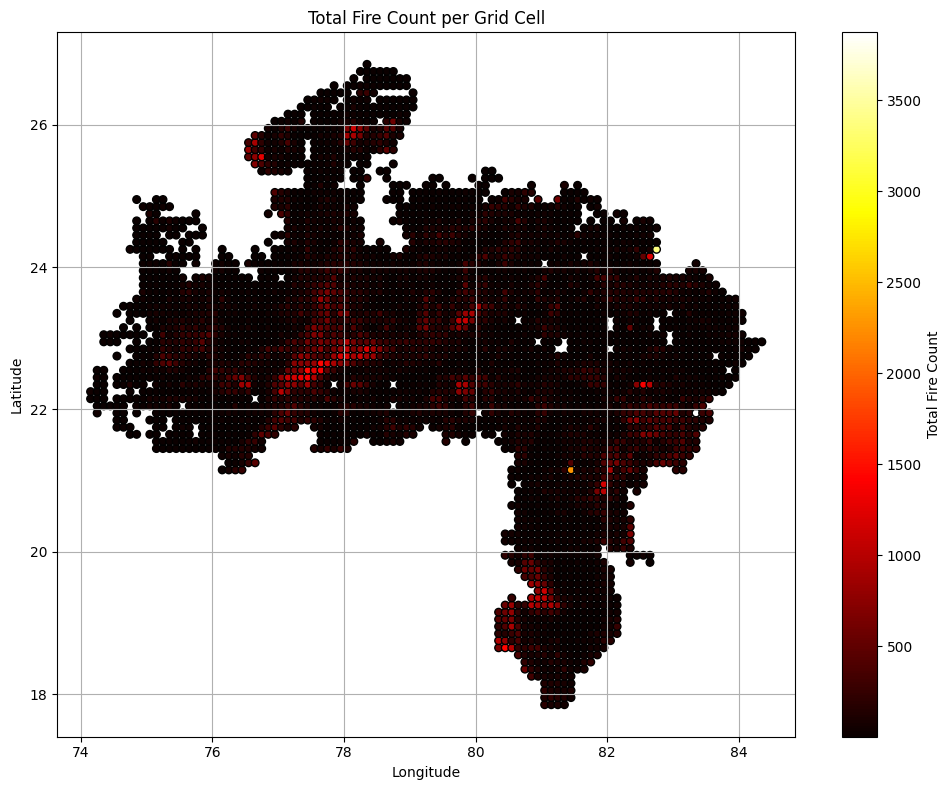

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('study_area_forest_fires.csv')

# Group by lat-lon and sum fire counts over time
agg_df = df.groupby(['lat', 'lon'], as_index=False)['count'].sum()

# Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(agg_df['lon'], agg_df['lat'], c=agg_df['count'], cmap='hot', s=30, edgecolor='k')
plt.colorbar(sc, label='Total Fire Count')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total Fire Count per Grid Cell')
plt.grid(True)
plt.tight_layout()
plt.show()